In [ ]:
#! /bin/bash


export PYTHONUNBUFFERED="True"

# Parameters
GPU_DEV=0
CONFIG_FILE=models/trancos/ccnn/ccnn_trancos_cfg.yml
#CAFFE_MODEL=models/pretrained_models/trancos/ccnn/trancos_ccnn.caffemodel
CAFFE_MODEL=our_scale/ccnn_trancos_iter.caffemodel
DEPLOY=models/trancos/ccnn/ccnn_deploy.prototxt

LOG="experiments/logs/trancos_ccnn_`date +'%Y-%m-%d_%H-%M-%S'`.txt"
exec &> >(tee -a "$LOG")
echo Logging output to "$LOG"

# Time the task
T="$(date +%s)"

# Test Net
python src/test.py --dev ${GPU_DEV} --prototxt ${DEPLOY} --caffemodel ${CAFFE_MODEL} --cfg ${CONFIG_FILE}

T="$(($(date +%s)-T))"
echo "Time in seconds: ${T}"

In [3]:
#import sys
#sys.path.append('~/caffe/python/')
#sys.path.append('~/caffe/python/caffe')
#sys.path.insert(0,'~/caffe/python/')
import h5py
import scipy.io as sio
import matplotlib.pyplot as plt

# System
import signal
import sys, getopt
signal.signal(signal.SIGINT, signal.SIG_DFL)
import time

# Vision and maths
import numpy as np
from matplotlib import cm as CM
import utils as utl
from gen_features import genDensity, genPDensity, loadImage, extractEscales
# import caffe_header
import caffe
import cv2

In [4]:
class CaffePredictor:
    def __init__(self, prototxt, caffemodel, n_scales):       
        # Load a precomputed caffe model
        self.net = caffe.Net(prototxt, caffemodel, caffe.TEST)
        
        # input preprocessing: 'data' is the name of the input blob == net.inputs[0]
        self.transformer = caffe.io.Transformer({'data': self.net.blobs['data_s0'].data.shape})
        self.transformer.set_transpose('data', (2, 0, 1)) # It's already RGB
        # Reshape net for the single input
        b_shape = self.net.blobs['data_s0'].data.shape
        self._n_scales = n_scales
        for s in range(n_scales):
            scale_name = 'data_s{}'.format(s)
            self.net.blobs[scale_name].reshape(b_shape[0],b_shape[1],b_shape[2],b_shape[3])

    # Probably it is not the eficient way to do it...
    def process(self, im, base_pw):
        # Compute dense positions where to extract patches
        [heith, width] = im.shape[0:2]
        pos = utl.get_dense_pos(heith, width, base_pw, stride=3)

        # Initialize density matrix and vouting count
        dens_map = np.zeros( (heith, width), dtype = np.float32 )   # Init density to 0
        count_map = np.zeros( (heith, width), dtype = np.int32 )     # Number of votes to divide

        # print('pos',len(pos))
        # exit(0)
        
        # Iterate for all patches
        for ix, p in enumerate(pos):
            # Compute displacement from centers
            dx=dy=int(base_pw/2)
    
            # Get roi
            x,y=p
            sx=slice(x-dx,x+dx+1,None)
            sy=slice(y-dy,y+dy+1,None)
            crop_im=im[sx,sy,...]
            h, w = crop_im.shape[0:2]
            if h!=w or (h<=0):
                continue
            
            # Get all the scaled images
            im_scales = extractEscales([crop_im], self._n_scales)
            
            # Load and forward CNN
            for s in range(self._n_scales):
                data_name = 'data_s{}'.format(s)
                self.net.blobs[data_name].data[...] = self.transformer.preprocess('data', im_scales[0][s].copy())
            self.net.forward()
            
            # Take the output from the last layer
            # Access to the last layer of the net, second element of the tuple (layer, caffe obj)
            pred = self.net.blobs.items()[-1][1].data
            
            # Make it squared
            p_side = int(np.sqrt( len( pred.flatten() ) )) 
            pred = pred.reshape(  (p_side, p_side) )
            
            # Resize it back to the original size
            pred = utl.resizeDensityPatch(pred, crop_im.shape[0:2])          
            pred[pred<0] = 0

            pred = cv2.blur(pred,(9,9))

            # Sumup density map into density map and increase count of votes
            dens_map[sx,sy] += pred
            count_map[sx,sy] += 1

            # kernel = np.ones((1,1),dtype='float')*(1.0/(1*1))
            # dens_map = cv2.filter2D(dens_map,-1,kernel)

        # Remove Zeros
        count_map[ count_map == 0 ] = 1



        # kernel = np.ones((1,1),dtype='float')*(1.0/(1*1))
        # dens_map = cv2.filter2D(dens_map,-1,kernel)

        # Average density map
        dens_map = dens_map / count_map        
        
        return dens_map

In [5]:
def initTestFromCfg(cfg_file):
    '''
    @brief: initialize all parameter from the cfg file. 
    '''
    
    # Load cfg parameter from yaml file
    cfg = utl.cfgFromFile(cfg_file)
    
    # Fist load the dataset name
    dataset = cfg.DATASET
    
    # Set default values
    use_mask = cfg[dataset].USE_MASK
    use_perspective = cfg[dataset].USE_PERSPECTIVE
    
    # Mask pattern ending
    mask_file = cfg[dataset].MASK_FILE
        
    # Img patterns ending
    dot_ending = cfg[dataset].DOT_ENDING
    
    # Test vars
    test_names_file = cfg[dataset].TEST_LIST
    
    # Im folder
    im_folder = cfg[dataset].IM_FOLDER
    
    # Results output foder
    results_file = cfg[dataset].RESULTS_OUTPUT

    # Resize image
    resize_im = cfg[dataset].RESIZE

    # Patch parameters
    pw = cfg[dataset].PW # Patch with 
    sigmadots = cfg[dataset].SIG # Densities sigma
    n_scales = cfg[dataset].N_SCALES # Escales to extract
    perspective_path = cfg[dataset].PERSPECTIVE_MAP
    is_colored = cfg[dataset].COLOR

        
    return (dataset, use_mask, mask_file, test_names_file, im_folder, 
            dot_ending, pw, sigmadots, n_scales, perspective_path, 
            use_perspective, is_colored, results_file, resize_im)

In [6]:
# Init parameters      
use_cpu = True
gpu_dev = 0

# GAME max level
mx_game = 4 # Max game target

# Batch size
b_size = -1

# CNN vars
# prototxt_path = 'models/trancos/hydra2/hydra_deploy.prototxt'
# caffemodel_path = 'models/trancos/hydra2/trancos_hydra2.caffemodel'

prototxt_path='../models/trancos/ccnn/ccnn_deploy.prototxt'
caffemodel_path='../our_scale/ccnn_trancos_iter.caffemodel'
cfg_file='../models/trancos/ccnn/ccnn_trancos_cfg.yml'

In [7]:
(dataset, use_mask, mask_file, test_names_file, im_folder, 
        dot_ending, pw, sigmadots, n_scales, perspective_path, 
        use_perspective, is_colored, results_file, resize_im) = initTestFromCfg(cfg_file)

utils.py:34: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  yaml_cfg = edict(yaml.load(f))


In [8]:
# Set GPU CPU setting
if use_cpu:
    caffe.set_mode_cpu()
else:
    # Use GPU
    caffe.set_device(gpu_dev)
    caffe.set_mode_gpu()

In [9]:
if use_perspective:
    pers_file = h5py.File(perspective_path,'r')
    pmap = np.array( pers_file['pmap'] )
    pers_file.close()

mask = None
if dataset == 'UCSD':
    print "Reading mask"
    if use_mask:
        mask_f = h5py.File(mask_file,'r')
        mask = np.array(mask_f['mask'])
        mask_f.close()

print "Reading image file names:"
im_names = np.loadtxt('.'+test_names_file, dtype='str')

Reading image file names:


In [90]:
name = '2.jpg'

In [91]:
im_path = utl.extendName(name, '.'+im_folder)
dot_im_path = utl.extendName(name, im_folder, use_ending=True, pattern=dot_ending)

# Read image files
im = loadImage(im_path, color = is_colored)

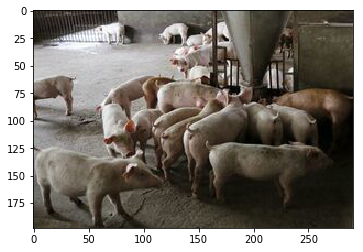

In [92]:
plt.imshow(im)

In [14]:
# Init CNN
CNN = CaffePredictor(prototxt_path, caffemodel_path, n_scales)

In [121]:
resImg = CNN.process(im, pw) 

In [153]:
heatmap = cv2.applyColorMap(
    np.uint8(255*(resImg - resImg.min())/(resImg.max() - resImg.min())),
    cv2.COLORMAP_JET
)

In [155]:
res = np.uint8(0.7*np.uint(255*im)) + np.uint8(0.3*heatmap)

In [161]:
font = cv2.FONT_HERSHEY_SIMPLEX
cv2.putText(res, str(resImg.sum().round()), (10,450), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
cv2.imwrite('pillar_text.jpg', res)

True

In [176]:
res.shape

(640, 352, 3)

In [181]:
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]
image, _ = cv2.imencode('.jpg', image, encode_param)
image = cv2.imdecode(image, 1)

#cv2.imshow('Decoded image',decimg)

In [182]:
cv2.imwrite(video_dir[:-6]+"/decimg.jpg", decimg)

True

In [188]:
success, image = vidcap.read()

In [190]:
image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
image, _ = cv2.imencode('.jpg', image, encode_param)

In [191]:
image

True

In [193]:
%%time
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 15]
video_dir = '../dymov_ug/1.mp4'
vidcap = cv2.VideoCapture(video_dir)
success = True
count = 0
while success:
    success, image = vidcap.read()
    count += 1
    if count % 2 == 0:
        print 'proccessing frame %d' % count
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        _, image = cv2.imencode('.jpg', image, encode_param)
        image = cv2.imdecode(image, 1)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        resImg = CNN.process(image, pw) 
        heatmap = cv2.applyColorMap(
            np.uint8(255*(resImg - resImg.min())/(resImg.max() - resImg.min())),
            cv2.COLORMAP_JET
        ) 
        res = np.uint8(0.7*np.uint8(255*image)) + np.uint8(0.3*heatmap)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(res, str(resImg.sum().round()), (10, 450), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imwrite(video_dir[:-6]+"/%d.jpg" % count, res)

proccessing frame 2
proccessing frame 4
proccessing frame 6
proccessing frame 8
proccessing frame 10
proccessing frame 12
proccessing frame 14
proccessing frame 16
proccessing frame 18
proccessing frame 20
proccessing frame 22
proccessing frame 24
proccessing frame 26
proccessing frame 28
proccessing frame 30
proccessing frame 32
proccessing frame 34
proccessing frame 36
proccessing frame 38
proccessing frame 40
proccessing frame 42
proccessing frame 44
proccessing frame 46
proccessing frame 48
proccessing frame 50
proccessing frame 52
proccessing frame 54
proccessing frame 56
proccessing frame 58
proccessing frame 60
proccessing frame 62
proccessing frame 64
proccessing frame 66
proccessing frame 68
proccessing frame 70
proccessing frame 72
proccessing frame 74
proccessing frame 76
proccessing frame 78
proccessing frame 80
proccessing frame 82
proccessing frame 84
proccessing frame 86
proccessing frame 88
proccessing frame 90
proccessing frame 92
proccessing frame 94
proccessing frame

KeyboardInterrupt: 

In [ ]:
%%time
encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 50]
video_dir = '../dymov_ug/3.mp4'
vidcap = cv2.VideoCapture(video_dir)
success = True
count = 0
while success:
    success, image = vidcap.read()
    count += 1
    if count % 4 == 0:
        print 'proccessing frame %d' % count
        image = cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        _, image = cv2.imencode('.jpg', image, encode_param)
        image = cv2.imdecode(image, 1)
        image = cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

        resImg = CNN.process(image, pw) 
        heatmap = cv2.applyColorMap(
            np.uint8(255*(resImg - resImg.min())/(resImg.max() - resImg.min())),
            cv2.COLORMAP_JET
        ) 
        res = np.uint8(0.7*np.uint8(255*image)) + np.uint8(0.3*heatmap)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(res, str(resImg.sum().round()), (10, 450), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
        cv2.imwrite(video_dir[:-6]+"/4_%d.jpg" % count, res)